In [1]:
#Import dependencies
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, inspect
from sqlalchemy.ext.automap import automap_base

#  Reflect Tables into SQLAlchemy ORM

In [2]:
#create an aneine to connect to sqlite database warehouse
engine = create_engine("sqlite:///Resources/hawaii.sqlite")



In [3]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [4]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [5]:
#use inspector as alternate to get more info from database
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [6]:
#get columns and first 5 rows of tables
#measurment table
conn = engine.connect()
columns1 = inspector.get_columns('measurement')
for c in columns1:
    print(c["name"],c["type"])
    
table1 = pd.read_sql("SELECT * FROM measurement", conn)
table1.head(5)



id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0


In [7]:
#station table

columns2 = inspector.get_columns('station')
for c in columns2:
    print(c["name"],c["type"])
    
table2 = pd.read_sql("SELECT * FROM station", conn)
table2.head(5)

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.3934,-157.9751,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.4992,-158.0111,306.6


# Exploratory Climate Analysis

####  Precipitation Analysis

In [8]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

query = """
    SELECT
        date, prcp
    FROM
        measurement
    WHERE
        date>= (
            SELECT 
                date(Max(date), '-365 day')
            FROM
                measurement
            
             )
    ORDER BY date

"""

In [9]:
#show in the dataframe table
df = pd.read_sql(query,con=conn) 
df.head()

,date,prcp
0,2016-08-23,0.00
1,2016-08-23,0.15
2,2016-08-23,0.05
3,2016-08-23,NaN
4,2016-08-23,0.02


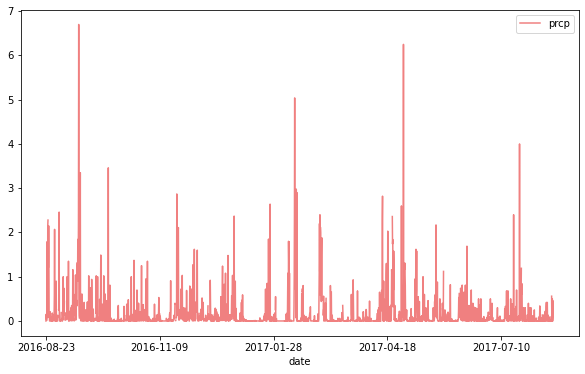

In [10]:
df.set_index("date").plot(color="lightcoral",figsize=(10,6))

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


#### Station Analysis

In [12]:
# Design a query to show how many stations are available in this dataset?

query = """
    SELECT
        count(*) as station_count
    FROM
        station
"""

In [13]:
conn = engine.connect()
df = pd.read_sql(query, con=conn)

df

,station_count
0,9


In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
query = """
    SELECT
        s.station,
        count(*) as tot_count
    FROM
        station s
    JOIN
        measurement m on s.station = m.station
    GROUP BY
        s.station
    ORDER BY
        count(*) desc
        
"""

In [15]:
conn = engine.connect()
df = pd.read_sql(query, con=conn)

df

,station,tot_count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [16]:
print (f'The most active staion is: {df.iloc[0,0]}')

The most active staion is: USC00519281


In [17]:
# Choose the station with the highest number of temperature observations.
query = """
        SELECT
            m.date,
            m.tobs,
            s.station
        FROM
            measurement m
            join station s on m.station = s.station

        ORDER BY
            date
        """

In [18]:
conn = engine.connect()
df = pd.read_sql(query, con=conn)

df

,date,tobs,station
0,2010-01-01,65.0,USC00519397
1,2010-01-01,67.0,USC00513117
2,2010-01-01,72.0,USC00518838
3,2010-01-01,75.0,USC00519523
4,2010-01-01,70.0,USC00519281
...,...,...,...
19545,2017-08-22,76.0,USC00516128
19546,2017-08-23,81.0,USC00519397
19547,2017-08-23,82.0,USC00514830
19548,2017-08-23,82.0,USC00519523


In [19]:
mostActive = df.groupby("station").size().sort_values(ascending=False).index[0]
print (f'The station with the highest number of temperature observations: {mostActive}')


The station with the highest number of temperature observations: USC00519281


In [26]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
query = """
    SELECT
        s.station,tobs
    FROM
        measurement m
    JOIN station s on m.station = s.station
    WHERE
        date>= (
            SELECT 
                date(Max(date), '-365 day')
            FROM
                measurement
                )
    ORDER BY date

"""

In [27]:
conn = engine.connect()
df = pd.read_sql(query, con=conn)
df

,station,tobs
0,USC00519397,81.0
1,USC00513117,76.0
2,USC00514830,80.0
3,USC00517948,80.0
4,USC00519523,80.0
...,...,...
2225,USC00516128,76.0
2226,USC00519397,81.0
2227,USC00514830,82.0
2228,USC00519523,82.0


In [28]:
df_sub = df.loc[df.station == mostActive].reset_index(drop=True)
df_sub

,station,tobs
0,USC00519281,77.0
1,USC00519281,77.0
2,USC00519281,80.0
3,USC00519281,80.0
4,USC00519281,75.0
...,...,...
347,USC00519281,77.0
348,USC00519281,77.0
349,USC00519281,76.0
350,USC00519281,76.0


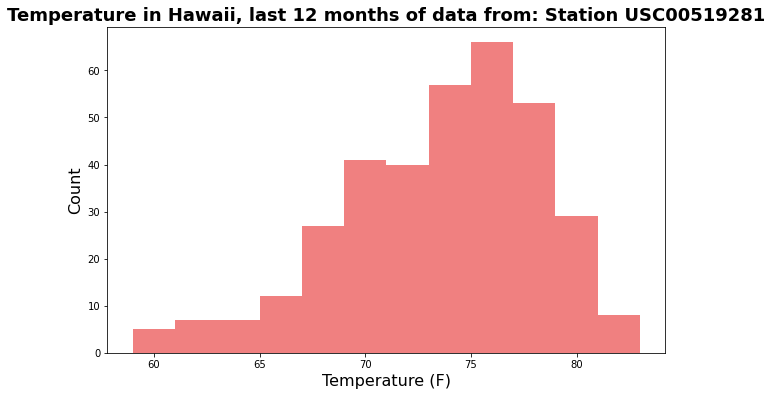

In [30]:
plt.figure(figsize=(10,6))
plt.hist(df_sub.tobs, bins=12,color="lightcoral")
plt.title(f"Temperature in Hawaii, last 12 months of data from: Station {mostActive}", fontweight="bold", fontsize=18)
plt.ylabel("Count", fontsize=16)
plt.xlabel("Temperature (F)", fontsize=16)

plt.show()